In [84]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [113]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import folium
import problem
import xgboost as xgb

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
import os
from sklearn.ensemble import GradientBoostingClassifier


In [114]:
external_data = pd.read_csv('submissions\external_data\external_data.csv')
data = pd.read_parquet(Path("data") / "train.parquet")
external_data.head()
__file__ = os.path.join('submissions', 'starting_kit', 'estimator.py')

In [115]:
data.groupby(["site_name", "counter_name"])["bike_count"].sum().sort_values(
    ascending=False
).head(10).to_frame()

,,bike_count
site_name,counter_name,
Totem 73 boulevard de Sébastopol,Totem 73 boulevard de Sébastopol S-N,1809231.0
Totem 64 Rue de Rivoli,Totem 64 Rue de Rivoli O-E,1406900.0
Totem 73 boulevard de Sébastopol,Totem 73 boulevard de Sébastopol N-S,1357868.0
67 boulevard Voltaire SE-NO,67 boulevard Voltaire SE-NO,1036575.0
Totem 64 Rue de Rivoli,Totem 64 Rue de Rivoli E-O,914089.0
27 quai de la Tournelle,27 quai de la Tournelle SE-NO,888717.0
Quai d'Orsay,Quai d'Orsay E-O,849724.0
Totem Cours la Reine,Totem Cours la Reine O-E,806149.0
Face au 48 quai de la marne,Face au 48 quai de la marne SO-NE,806071.0


In [116]:
def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    #X.loc[:, "year"] = X["date"].dt.year
    X.loc[:, "month"] = X["date"].dt.month
    #X.loc[:, "day"] = X["date"].dt.day
    X.loc[:, "weekday"] = X["date"].dt.weekday
    X.loc[:, "hour"] = X["date"].dt.hour

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"])

def _merge_external_data(X):
    file_path = Path(__file__).parent / "external_data.csv"
    df_ext = pd.read_csv(file_path, parse_dates=["date"])

    X = X.copy()
    # When using merge_asof left frame need to be sorted
    X["orig_index"] = np.arange(X.shape[0])
    X = pd.merge_asof(
        X.sort_values("date"), df_ext[['date', 't', 'u']].sort_values("date"), on="date"
    )
    # Sort back to the original order
    
    X = X.sort_values("orig_index")
    del X["orig_index"]
    return X

In [117]:
'''Checking influence of a data on the count
X_new = _merge_external_data(X_train)
data_toplot = np.vstack((X_new.rr3, y_train)).T
data_toplot2 = data_toplot[np.argsort(data_toplot[:,0])]
data_toplot2 = pd.DataFrame(data_toplot2).groupby([0]).mean()
temp = data_toplot2.index
plt.scatter(temp, data_toplot2)

'''

'Checking influence of a data on the count\nX_new = _merge_external_data(X_train)\ndata_toplot = np.vstack((X_new.rr3, y_train)).T\ndata_toplot2 = data_toplot[np.argsort(data_toplot[:,0])]\ndata_toplot2 = pd.DataFrame(data_toplot2).groupby([0]).mean()\ntemp = data_toplot2.index\nplt.scatter(temp, data_toplot2)\n\n'

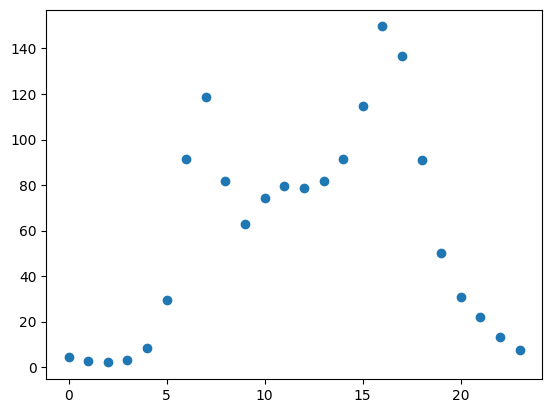

In [121]:
#Checking influence of a data on the count
X_new = _encode_dates(_merge_external_data(data))
data_toplot = np.vstack((X_new.hour, data.bike_count)).T
data_toplot2 = data_toplot[np.argsort(data_toplot[:,0])]
data_toplot2 = pd.DataFrame(data_toplot2).groupby([0]).mean()
temp = data_toplot2.index
plt.scatter(temp, data_toplot2)


In [110]:
#Preprocessor functions
categorical_encoder = OneHotEncoder(handle_unknown="ignore")

#Pipeline functions
date_encoder = FunctionTransformer(_encode_dates, validate=False)
data_merger = FunctionTransformer(_merge_external_data, validate=False)

#Columns by type
X_train, y_train = problem.get_train_data()
X_test, y_test = problem.get_test_data()
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()
categorical_cols = ["counter_name", "site_name"]

In [111]:
preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
        ("standard scaler", StandardScaler(), ['u', 't'])
        #("passthrough", "passthrough", ['u', 't'])
    ], #remainder='passthrough'
)

regressor = xgb.XGBRegressor()

pipe = Pipeline(
    steps=[
        ('merge external data', data_merger),
        ('date encoder', date_encoder),
        ('preprocessor', preprocessor),
        ('regressor',regressor)
    ]
)

In [112]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('merge external data',
                 FunctionTransformer(func=<function _merge_external_data at 0x000001A2007D8670>)),
                ('date encoder',
                 FunctionTransformer(func=<function _encode_dates at 0x000001A2031D7CA0>)),
                ('preprocessor',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handl...
                              feature_types=None, gamma=0, gpu_id=-1,
                              grow_policy='depthwise', importance_type=None,
                              interaction_constraints='',
                              learning_rate=0.300000012, max_bin=256,
                              max_cat_threshold=64, max_cat_to_onehot=4,
                              max_delta_step=0, max_depth=6, max_leaves=0,
                              min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=0, num_parallel_tree=1, predictor='auto',
                              random_state=0, ...))])

In [103]:
from sklearn.metrics import mean_squared_error

print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.2f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_test, pipe.predict(X_test), squared=False):.2f}"
)

Train set, RMSE=0.53
Test set, RMSE=0.49


In [93]:
print("Baseline mean prediction.")
print(
    f"Train set, RMSE={mean_squared_error(y_train, np.full(y_train.shape, y_train.mean()), squared=False):.2f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_test, np.full(y_test.shape, y_test.mean()), squared=False):.2f}"
)

Baseline mean prediction.
Train set, RMSE=1.68
Test set, RMSE=1.44


Text(0, 0.5, 'bike_count')

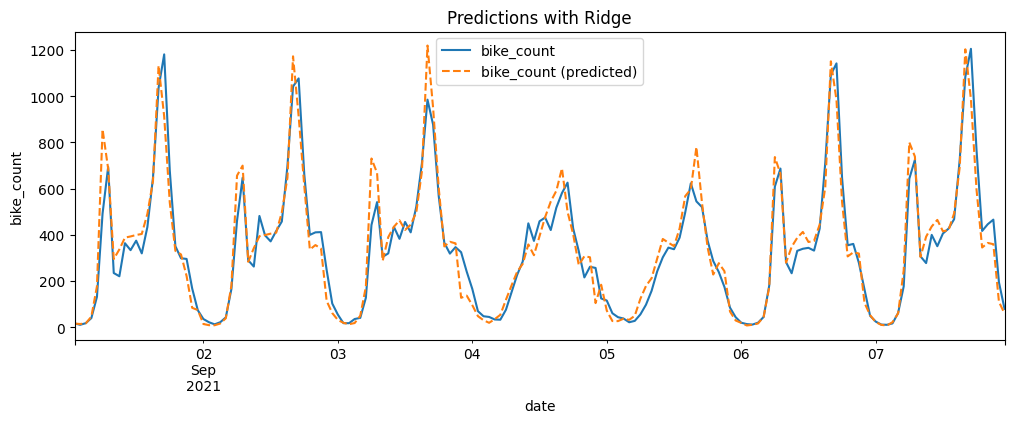

In [94]:
mask = (
    (X_test["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X_test["date"] > pd.to_datetime("2021/09/01"))
    & (X_test["date"] < pd.to_datetime("2021/09/08"))
)

df_viz = X_test.loc[mask].copy()
df_viz["bike_count"] = np.exp(y_test[mask.values]) - 1
df_viz["bike_count (predicted)"] = np.exp(pipe.predict(X_test[mask])) - 1

fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x="date", y="bike_count", ax=ax)
df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with Ridge")
ax.set_ylabel("bike_count")

<AxesSubplot: xlabel='y_true', ylabel='y_pred'>

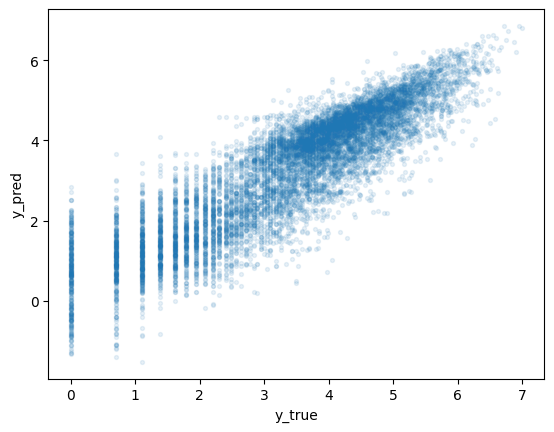

In [13]:
fig, ax = plt.subplots()

df_viz = pd.DataFrame({"y_true": y_test, "y_pred": pipe.predict(X_test)}).sample(
    10000, random_state=0
)

df_viz.plot.scatter(x="y_true", y="y_pred", s=8, alpha=0.1, ax=ax)

In [104]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

cv = TimeSeriesSplit(n_splits=6)

# When using a scorer in scikit-learn it always needs to be better when smaller, hence the minus sign.
scores = cross_val_score(
    pipe, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
)
print("RMSE: ", scores)
print(f"RMSE (all folds): {-scores.mean():.3} ± {(-scores).std():.3}")

RMSE:  [-0.84435067 -0.81297516 -0.72650145 -0.79202414 -0.83769913 -0.75472118]
RMSE (all folds): 0.795 ± 0.0426
